In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.VarianceRedFunc as vr 
import MH4518.WY.Utils.GBM as gbm 
import warnings
warnings.filterwarnings("ignore")
import MH4518.WY.Utils.ProductPrice as pp 


%reload_ext autoreload
%autoreload 2

In [2]:
def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()
data

[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120544,237.429871
2023-04-28,546.263306,242.368103
2023-05-02,545.868835,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [3]:
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': (0.08 / 4) ,  # Quarterly coupon payments
}

# Control Variate 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import pandas as pd

# Assuming 'dates', 'gbm', 'cs', 'data', 'pf', and 'params_product' are already imported or defined

def process_fdos(args):
    try:
        fdos, data_slice = args  # Unpack the arguments
        print(f"Processing FDOS: {fdos}")
        # Run the simulation
        sim_T = gbm.multi_asset_gbm_n_sims(plot=False, plotasset=False, nsims=cs.n_sims, data=data_slice, fdos=fdos)
        # Extract asset paths
        lonza_path = sim_T['LONN.SW']
        sika_path = sim_T['SIKA.SW']
        # Calculate payoffs
        payoff_gbm = pf.payoff(paths1=lonza_path, paths2=sika_path, params=params_product, fdos = fdos)
        theta_cv = vr.cv(data = data, lonza_path=lonza_path, sika_path=sika_path, fdos = fdos, payoffs_gbm=payoff_gbm)
        # expected payoff 
        expected_payoff_mc = np.mean(payoff_gbm)
        expected_payoff_cv= np.mean(theta_cv)
        # Discount to present value (assuming present value as of fdos)
        r = cs.interest_rate  # Use the same interest rate as in the simulation
        T_discount = dates.num_business_days(fdos, cs.final_fixing_date) / 252  # Time in years
        present_value_mc = expected_payoff_mc * np.exp(-(r) * T_discount)
        present_value_cv = present_value_cv = expected_payoff_cv * np.exp(-(r) * T_discount)
        # Return the present value
        return present_value_mc, present_value_cv
    except Exception as e:
        print(f"Error processing FDOS {fdos}: {e}")
        return None  # or some default value






In [ ]:
if __name__ == '__main__':
    date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
    date_list = pd.Series(date_list).tolist()
    # date_list = date_list[:60]  # Uncomment to limit the number of dates for testing

    T = date_list

    # Prepare arguments for multiprocessing
    # If 'data' is large, you can slice it or load it within the function
    data_slices = [data for _ in T]  # Assuming 'data' is the same for all dates

    # Combine the dates and data slices into a list of tuples
    args_list = list(zip(T, data_slices))

    # Set up the multiprocessing pool
    num_processes = mp.cpu_count()  # You can adjust this number
    with mp.Pool(processes=num_processes) as pool:
        # Map the function to the arguments
        present_value_= pool.map(process_fdos, args_list)


    # Now 'present_value_list' contains the results
    # You can proceed to process or store these results as needed

In [6]:
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
date_list = pd.Series(date_list).tolist()
data_slices = [data for _ in T] 
# date_list = date_list[:60]  # Uncomment to limit the number of dates for testing

T = date_list
args_list = list(zip(T, data_slices))
args_list

[(Timestamp('2023-04-27 00:00:00'),
  Ticker         LONN.SW     SIKA.SW
  Date                              
  2023-04-27  542.120544  237.429871
  2023-04-28  546.263306  242.368103
  2023-05-02  545.868835  239.800232
  2023-05-03  574.079590  241.479218
  2023-05-04  572.895935  242.071823
  ...                ...         ...
  2024-07-24  522.599976  262.000000
  2024-07-25  559.799988  258.500000
  2024-07-26  581.000000  262.000000
  2024-07-29  575.200012  263.700012
  2024-07-30  578.799988  269.100006
  
  [316 rows x 2 columns]),
 (Timestamp('2023-04-28 00:00:00'),
  Ticker         LONN.SW     SIKA.SW
  Date                              
  2023-04-27  542.120544  237.429871
  2023-04-28  546.263306  242.368103
  2023-05-02  545.868835  239.800232
  2023-05-03  574.079590  241.479218
  2023-05-04  572.895935  242.071823
  ...                ...         ...
  2024-07-24  522.599976  262.000000
  2024-07-25  559.799988  258.500000
  2024-07-26  581.000000  262.000000
  2024-07-

In [39]:
import warnings
warnings.filterwarnings("ignore")
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
date_list = pd.Series(date_list).tolist()
#date_list = date_list.head(10).tolist()

T = date_list
present_value_mc_list = []
present_value_cv_list = []
for fdos in T:  
    print(f"Processing FDOS: {fdos}")

    # Run the simulation
    sim_T = gbm.multi_asset_gbm_n_sims(plot = False, plotasset= False, nsims = 10, data = data, fdos = fdos )
    lonza_path = sim_T['LONN.SW']
    sika_path = sim_T['SIKA.SW']
    payoff_gbm = pf.payoff(paths1=lonza_path, paths2=sika_path, params=params_product, fdos = fdos)

    theta_cv = vr.cv(data = data, lonza_path=lonza_path, sika_path=sika_path, fdos = fdos, payoffs_gbm=payoff_gbm)
    
    expected_payoff_mc = np.mean(payoff_gbm)
    # Compute expected payoff of CV 
    expected_payoff_cv= np.mean(theta_cv)
    # Discount to present value (assuming present value as of fdos)
    r = cs.interest_rate  # Use the same interest rate as in the simulation
    T_discount = dates.num_business_days(fdos, cs.final_fixing_date) / 252  # Time in years
    present_value_mc = expected_payoff_mc * np.exp(-(r) * T_discount)
    present_value_cv = present_value_cv = expected_payoff_cv * np.exp(-(r) * T_discount)
    print(f"Expected MC payoff at {fdos}", present_value_mc)
    print(f"Expected CV payoff at {fdos}", present_value_cv)
    # Store the present value
    present_value_mc_list.append(present_value_mc)
    present_value_cv_list.append(present_value_cv)

Processing FDOS: 2023-04-27 00:00:00
Length of date_list: 315
Number of time steps (num_steps): 315
[90.4561475  86.79089897 94.57202286 81.8824196  72.09721557 99.19106943
 96.5036336  96.15197314 84.84148337 96.86846566]
E_Y (Analytical Expected Value): 99.64867963029275
Mean of Simulated Control Variate Payoffs (bar_Y): 89.93553296997206
Correlation between X and Y: -0.0759
Beta (β) Coefficient: -0.21053092208705299
NaN in payoffs_gbm: False
Inf in payoffs_gbm: False
NaN in payoffs_control_variate: False
Inf in payoffs_control_variate: False
Variance Reduction Achieved: 0.58%
CV Estimate Payoff : 1080.0950949359635
Expected MC payoff at 2023-04-27 00:00:00 1058.0637361934835
Expected CV payoff at 2023-04-27 00:00:00 1056.0643153600925
Processing FDOS: 2023-04-28 00:00:00
Length of date_list: 314
Number of time steps (num_steps): 314
[111.98226828  91.37396097  98.91103186 120.97811542 109.82883535
 111.85144599  96.8902302   92.37453772 101.4377067   98.61330252]
E_Y (Analytical Exp

<Axes: xlabel='date'>

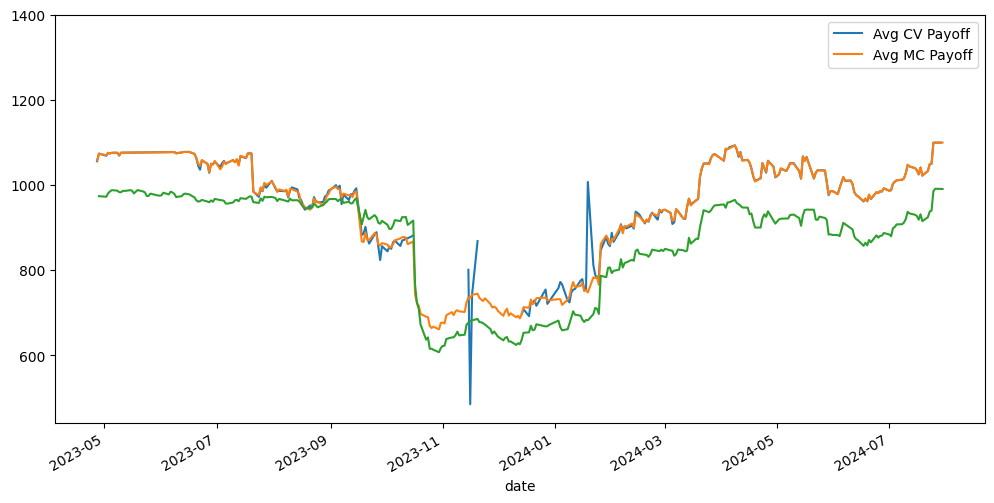

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
present_value_cv_df = pd.DataFrame({'Avg CV Payoff': present_value_cv_list}, index= T)
present_value_cv_df.plot(ax = ax)
present_value_mc_df = pd.DataFrame({'Avg MC Payoff': present_value_mc_list}, index = T )
present_value_mc_df.plot(ax = ax)
import json 
productprice = pp.get_product_price()
productprice.plot(ax = ax)
